In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import optimizers, activations, losses, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from glob import glob

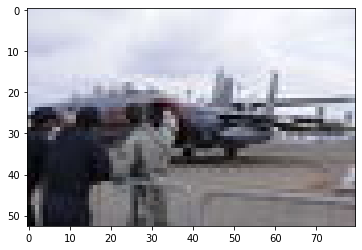

In [2]:
img = image.load_img('Training/Airplane/image2.jpg')
img = image.img_to_array(img)/255
plt.imshow(img)

In [3]:
img.shape

(53, 80, 3)

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('Training',
                                                target_size = (224, 224),
                                                batch_size = 128,
                                                class_mode = 'categorical')

Found 5176 images belonging to 6 classes.


In [5]:
valid_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = valid_datagen.flow_from_directory('Validation',
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = 'categorical')

Found 1293 images belonging to 6 classes.


In [6]:
input_shape = (224, 224, 3)
nclass = len(glob('Training/*'))

In [7]:
base_model = applications.InceptionV3(weights='imagenet',
                                     include_top = False,
                                     input_shape=input_shape)
base_model.trainable = False

In [8]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(nclass, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer = optimizers.SGD(lr=1e-4),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
file_path="model.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="val_accuracy", mode="max", patience=2)

callbacks_list = [checkpoint, early]

In [10]:
history = model.fit(training_set,
                  validation_data=validation_set, 
                  epochs=20, 
                  shuffle=True, 
                  verbose=True,
                  callbacks=callbacks_list)

Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 2.4504 - accuracy: 0.1640
Epoch 00001: val_accuracy improved from -inf to 0.18407, saving model to model.h5
41/41 [==============================] - 355s 9s/step - loss: 2.4504 - accuracy: 0.1640 - val_loss: 1.9496 - val_accuracy: 0.1841
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 2.1950 - accuracy: 0.2083
Epoch 00002: val_accuracy improved from 0.18407 to 0.25599, saving model to model.h5
41/41 [==============================] - 347s 8s/step - loss: 2.1950 - accuracy: 0.2083 - val_loss: 1.7560 - val_accuracy: 0.2560
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 2.0650 - accuracy: 0.2533
Epoch 00003: val_accuracy improved from 0.25599 to 0.32096, saving model to model.h5
41/41 [==============================] - 337s 8s/step - loss: 2.0650 - accuracy: 0.2533 - val_loss: 1.6591 - val_accuracy: 0.3210
Epoch 4/20
41/41 [==============================] - ETA: 0s - loss: 1.9891 -

In [23]:
model = tf.keras.models.load_model('model.h5')

In [24]:
test = pd.read_csv('test.csv')
test.head()

,Image
0,image10.jpg
1,image100.jpg
2,image1013.jpg
3,image1014.jpg
4,image1018.jpg


In [25]:
test['Image']

0         image10.jpg
1        image100.jpg
2       image1013.jpg
3       image1014.jpg
4       image1018.jpg
            ...      
3484    image9953.jpg
3485    image9956.jpg
3486    image9958.jpg
3487    image9960.jpg
3488     image997.jpg
Name: Image, Length: 3489, dtype: object

In [35]:
path = "test/"
y_pred = []
for i in range(len(test)):
    name = test.loc[i]['Image']
    loc = path+name
    img = image.load_img(loc, target_size = (224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    
    images = np.vstack([x])
    classes = model.predict(images)
    y_pred.append(np.argmax(classes))

In [14]:
train_df = pd.read_csv('train.csv')
classes = pd.DataFrame(train_df['Class'].unique(), columns = ['class_of_image'])
classes

,class_of_image
0,Miscellaneous
1,Candle
2,Snowman
3,Airplane
4,Christmas_Tree
5,Jacket


In [36]:
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        y_pred[i] = "Airplane"
    elif y_pred[i]== 1:
        y_pred[i] = "Candle"
    elif y_pred[i]== 2:
        y_pred[i] = "Christmas_Tree"
    elif y_pred[i]== 3:
        y_pred[i] = "Jacket"
    elif y_pred[i]== 4:
        y_pred[i] = "Miscellaneous"
    elif y_pred[i]== 5:
        y_pred[i] = "Snowman"
    

In [40]:
predict_datagen = ImageDataGenerator(rescale = 1./255)

In [43]:
predict_set = predict_datagen.flow_from_directory('test/',
                                            target_size = (224, 224),
                                            class_mode = 'categorical')

Found 3489 images belonging to 1 classes.


In [44]:
y_pred = model.predict(predict_set, verbose = 1)

110/110 [==============================] - 216s 2s/step


In [48]:
y_pred = np.argmax(y_pred, axis = 1)

In [60]:
y_pred = list(y_pred)

In [61]:
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        y_pred[i] = "Airplane"
    elif y_pred[i]== 1:
        y_pred[i] = "Candle"
    elif y_pred[i]== 2:
        y_pred[i] = "Christmas_Tree"
    elif y_pred[i]== 3:
        y_pred[i] = "Jacket"
    elif y_pred[i]== 4:
        y_pred[i] = "Miscellaneous"
    elif y_pred[i]== 5:
        y_pred[i] = "Snowman"

In [62]:
submission_df = pd.DataFrame(data = zip(test['Image'], y_pred), columns = ['Image', 'Class'])

In [63]:
submission_df.head()

,Image,Class
0,image10.jpg,Jacket
1,image100.jpg,Miscellaneous
2,image1013.jpg,Miscellaneous
3,image1014.jpg,Miscellaneous
4,image1018.jpg,Christmas_Tree


In [64]:
submission_df['Class'].value_counts()

Miscellaneous     2468
Christmas_Tree     793
Jacket             124
Candle              59
Airplane            42
Snowman              3
Name: Class, dtype: int64

In [65]:
submission_df.to_csv('submission2.csv', index = False)